In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Any

import numpy as np
from torch.utils.data import DataLoader,TensorDataset
import time
import matplotlib.pyplot as plt

In [2]:
class EncoderRNN(nn.Module):
    """Encoder Network."""
    def __init__(self,
                 input_size: int = 2,
                 embedding_size: int = 8,
                 hidden_size: int = 16):
        """Initialize the encoder network.
        Args:
            input_size: number of features in the input
            embedding_size: Embedding size
            hidden_size: Hidden size of LSTM
        """
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.linear1 = nn.Linear(input_size, embedding_size)
        self.lstm1 = nn.LSTMCell(embedding_size, hidden_size)

    def forward(self, x: torch.FloatTensor, hidden: Any) -> Any:
        """Run forward propagation.
        Args:
            x: input to the network
            hidden: initial hidden state
        Returns:
            hidden: final hidden 
        """
        embedded = F.relu(self.linear1(x))
        hidden = self.lstm1(embedded, hidden)
        return hidden


In [3]:
class DecoderRNN(nn.Module):
    """Decoder Network."""
    def __init__(self, embedding_size=8, hidden_size=16, output_size=2):
        """Initialize the decoder network.
        Args:
            embedding_size: Embedding size
            hidden_size: Hidden size of LSTM
            output_size: number of features in the output
        """
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.linear1 = nn.Linear(output_size, embedding_size)
        self.lstm1 = nn.LSTMCell(embedding_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        """Run forward propagation.
        Args:
            x: input to the network
            hidden: initial hidden state
        Returns:
            output: output from lstm
            hidden: final hidden state
        """
        embedded = F.relu(self.linear1(x))
        hidden = self.lstm1(embedded, hidden)
        output = self.linear2(hidden[0])
        return output, hidden

In [4]:
#train_set = train_set.transpose(0,2,1)
#train_target = train_target.transpose(0,2,1)
#train_set.shape,train_target.shape

train_data = np.load("train_velocity.npy")
train_data.shape

(208272, 2, 49)

In [5]:
toTensor_sig = torch.tensor(train_data)
train_data_set = TensorDataset(toTensor_sig)

In [6]:
#set up the train parameters
batch_size = 1000 #1000 #600 #500
epoch = 400
lr = 0.00001

encoder = EncoderRNN()
decoder = DecoderRNN()
criterion = nn.MSELoss()
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=lr)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
tr_data_loader = DataLoader(train_data_set,batch_size = batch_size, shuffle = True)
loss_overall = []

In [35]:

start = time.time()

for i in range(100):
    print("============================================")
    print("epoch: ", i+1)
    loss_batch = 0
    cur_MSE = 0
    for (idx,data) in enumerate(tr_data_loader):
        feature = data[0][:,:,0:29]#.permute(0,2,1)
        #print(feature.shape)
        target = data[0][:,:,29:49]
        #print(target)
        encoder_hidden =(
            torch.zeros(feature.shape[0], 16),
            torch.zeros(feature.shape[0], 16),
        )
        
        loss = 0
        
        
        for cur_fea in range(feature.shape[2]):
            encoder_input = feature[:,:,cur_fea]
            #print((encoder_input.shape))
            #print(encoder_hidden[0].dtype)
            encoder_hidden = encoder(encoder_input.type(torch.FloatTensor), encoder_hidden)
        
        # Initialize decoder input with last coordinate in encoder
        decoder_input = encoder_input[:, :2]
        #print(decoder_input.shape)

        # Initialize decoder hidden state as encoder hidden state
        decoder_hidden = encoder_hidden
        decoder_outputs = torch.zeros(target.shape)
        
        for di in range(20):
            decoder_output, decoder_hidden = decoder(decoder_input.type(torch.FloatTensor),
                                                     decoder_hidden)
            decoder_outputs[:, :, di] = decoder_output

            # Update losses for all benchmarks
            loss += criterion(decoder_output[:, :], target[:, :, di].type(torch.FloatTensor))
            

            # Use own predictions as inputs at next step
            decoder_input = decoder_output
            
        
        #loss = criterion(decoder_outputs, target.type(torch.FloatTensor))
        # Get average loss for pred_len
        #loss = (loss/batch_size).type(torch.FloatTensor)
        #cur_MSE += loss
        #print(loss.dtype)
        loss = loss/20
        loss_batch+= loss
        #print(loss)
        loss.backward()
        encoder_optimizer.step()
        #print("decoder")
        decoder_optimizer.step()
        #print(decoder_outputs)
        #print(target)
        #break
    #loss_overall.append(cur_MSE)
    print(loss_batch/batch_size)    #average loss per batch
    loss_overall.append(loss_batch/batch_size)





epoch:  1
tensor(0.7479, grad_fn=<DivBackward0>)
epoch:  2
tensor(0.7478, grad_fn=<DivBackward0>)
epoch:  3
tensor(0.7485, grad_fn=<DivBackward0>)
epoch:  4
tensor(0.7480, grad_fn=<DivBackward0>)
epoch:  5
tensor(0.7476, grad_fn=<DivBackward0>)
epoch:  6
tensor(0.7476, grad_fn=<DivBackward0>)
epoch:  7
tensor(0.7486, grad_fn=<DivBackward0>)
epoch:  8
tensor(0.7476, grad_fn=<DivBackward0>)
epoch:  9
tensor(0.7487, grad_fn=<DivBackward0>)
epoch:  10
tensor(0.7476, grad_fn=<DivBackward0>)
epoch:  11
tensor(0.7480, grad_fn=<DivBackward0>)
epoch:  12
tensor(0.7477, grad_fn=<DivBackward0>)
epoch:  13
tensor(0.7479, grad_fn=<DivBackward0>)
epoch:  14
tensor(0.7475, grad_fn=<DivBackward0>)
epoch:  15
tensor(0.7476, grad_fn=<DivBackward0>)
epoch:  16
tensor(0.7480, grad_fn=<DivBackward0>)
epoch:  17
tensor(0.7474, grad_fn=<DivBackward0>)
epoch:  18
tensor(0.7472, grad_fn=<DivBackward0>)
epoch:  19
tensor(0.7476, grad_fn=<DivBackward0>)
epoch:  20
tensor(0.7475, grad_fn=<DivBackward0>)
epoch:  2

tensor(0.7482, grad_fn=<DivBackward0>)
epoch:  88
tensor(0.7474, grad_fn=<DivBackward0>)
epoch:  89
tensor(0.7474, grad_fn=<DivBackward0>)
epoch:  90
tensor(0.7483, grad_fn=<DivBackward0>)
epoch:  91
tensor(0.7472, grad_fn=<DivBackward0>)
epoch:  92
tensor(0.7477, grad_fn=<DivBackward0>)
epoch:  93
tensor(0.7480, grad_fn=<DivBackward0>)
epoch:  94
tensor(0.7479, grad_fn=<DivBackward0>)
epoch:  95
tensor(0.7475, grad_fn=<DivBackward0>)
epoch:  96
tensor(0.7476, grad_fn=<DivBackward0>)
epoch:  97
tensor(0.7474, grad_fn=<DivBackward0>)
epoch:  98
tensor(0.7481, grad_fn=<DivBackward0>)
epoch:  99
tensor(0.7477, grad_fn=<DivBackward0>)
epoch:  100
tensor(0.7476, grad_fn=<DivBackward0>)


In [36]:
torch.save(encoder,'trained_encoder_1202_2.pth')
torch.save(decoder,'trained_decoder_1202_2.pth')

## Print learning curve

In [37]:

for i in range(len(loss_overall)):
    loss_overall[i] = loss_overall[i].detach().numpy()


AttributeError: 'numpy.ndarray' object has no attribute 'detach'

[array(6.3256183, dtype=float32), array(6.3140826, dtype=float32), array(6.306142, dtype=float32), array(6.2957854, dtype=float32), array(6.287679, dtype=float32), array(6.280286, dtype=float32), array(6.271278, dtype=float32), array(6.264508, dtype=float32), array(6.2542977, dtype=float32), array(6.2418613, dtype=float32), array(6.230923, dtype=float32), array(6.2220864, dtype=float32), array(6.204498, dtype=float32), array(6.1867037, dtype=float32), array(6.1695714, dtype=float32), array(6.1529603, dtype=float32), array(6.1257052, dtype=float32), array(6.1079416, dtype=float32), array(6.0777535, dtype=float32), array(6.0442324, dtype=float32), array(6.0081506, dtype=float32), array(5.9651723, dtype=float32), array(5.9156203, dtype=float32), array(5.8637786, dtype=float32), array(5.7992716, dtype=float32), array(5.719709, dtype=float32), array(5.6357536, dtype=float32), array(5.54032, dtype=float32), array(5.447449, dtype=float32), array(5.3611393, dtype=float32), array(5.2792277, dty

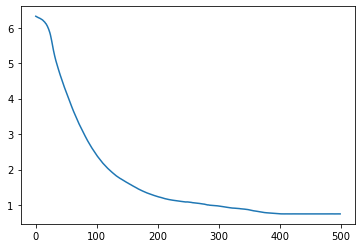

In [38]:
print(loss_overall)
plt.plot(loss_overall)
    

# Test

## test dataset

In [39]:
toTensor_sig = torch.tensor(train_data)
test_data_set = TensorDataset(toTensor_sig)

In [40]:
encoder = torch.load("trained_encoder_1202.pth")
decoder = torch.load("trained_decoder_1202.pth")

In [41]:
te_data_loader = DataLoader(test_data_set,batch_size = batch_size, shuffle = False)

In [42]:
predict = []
ground_truth = []
error = 0

In [43]:
for (idx,data) in enumerate(te_data_loader):
        feature = data[0][:,:,0:29]#.permute(0,2,1)
        #print(feature.shape)
        target = data[0][:,:,29:49]
        ground_truth.append(target)
        encoder_hidden =(
            torch.zeros(feature.shape[0], 16),
            torch.zeros(feature.shape[0], 16),
        )
        
        loss = 0
        
        
        for cur_fea in range(feature.shape[2]):
            encoder_input = feature[:,:,cur_fea]
            #print((encoder_input.shape))
            #print(encoder_hidden[0].dtype)
            encoder_hidden = encoder(encoder_input.type(torch.FloatTensor), encoder_hidden)
        
        # Initialize decoder input with last coordinate in encoder
        decoder_input = encoder_input[:, :2]

        # Initialize decoder hidden state as encoder hidden state
        decoder_hidden = encoder_hidden
        decoder_outputs = torch.zeros(target.shape)
        
        for di in range(20):
            decoder_output, decoder_hidden = decoder(decoder_input.type(torch.FloatTensor),decoder_hidden)
            decoder_outputs[:, :, di] = decoder_output

            # Update losses for all benchmarks
            loss += criterion(decoder_output[:, :], target[:, :, di].type(torch.FloatTensor))

            # Use own predictions as inputs at next step
            decoder_input = decoder_output
        error += loss
        loss = loss / 20
        predict.append(decoder_outputs)
        print(idx)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208


# Test

In [44]:
trajectory = np.load("train_trajectory.npy")

In [45]:
len(predict)

209

In [46]:
predict[0].size()[0]

1000

In [47]:
test = train_data

In [48]:
results = np.zeros((test.shape[0],2,20))
results.shape

(208272, 2, 20)

In [49]:
for i in range(len(predict)):
    for j in range(predict[i].size()[0]):
        results[i*1000+j] = predict[i][j].detach().numpy()

In [50]:
predict[0]

tensor([[[ 1.8348e+00,  1.1678e+00, -9.0002e-01,  ..., -8.7037e-01,
          -4.6124e-01,  3.1568e-01],
         [-7.6949e+00, -8.1436e+00, -9.8827e+00,  ..., -8.7843e+00,
          -8.3356e+00, -7.4836e+00]],

        [[-3.1610e-01,  2.7391e-01, -3.7661e-01,  ..., -1.5950e-01,
          -1.9197e-01, -1.8416e-01],
         [-6.1070e-02,  1.1042e-01,  6.8043e-01,  ...,  7.1721e-02,
          -7.5881e-03, -4.8456e-02]],

        [[ 8.7814e+00,  9.1614e+00,  9.2186e+00,  ...,  9.2278e+00,
           9.2278e+00,  9.2277e+00],
         [ 7.7019e+00,  8.1324e+00,  8.1973e+00,  ...,  8.2077e+00,
           8.2077e+00,  8.2077e+00]],

        ...,

        [[-3.2735e-01, -8.1438e-02, -1.8593e-01,  ..., -1.7497e-01,
          -1.7725e-01, -1.7928e-01],
         [-2.4689e-01,  1.1012e-01,  9.8084e-02,  ..., -3.5970e-02,
          -4.0927e-02, -5.0822e-02]],

        [[-3.2661e-01, -6.0787e-02, -2.1440e-01,  ..., -1.7797e-01,
          -1.7961e-01, -1.7729e-01],
         [-2.3071e-01,  1.0284e-0

In [51]:
tra = trajectory
tra.shape

(208272, 2, 50)

In [52]:
predicted_tras = np.zeros(tra.shape)

In [53]:
predicted_tras[:,:,0:30] = tra[:,:,0:30]
for i in range(30,50):
    predicted_tras[:,:,i] = predicted_tras[:,:,i-1] + results[:,:,i-30]*0.1

In [54]:
np.arange(1,208272,10)[20]

201

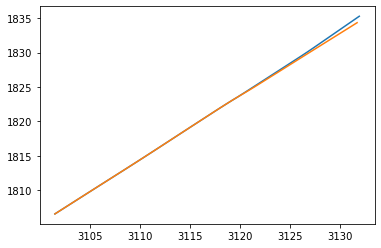

In [55]:
plt.plot(predicted_tras[201,0],predicted_tras[201,1])
plt.plot(tra[201,0],tra[201,1])

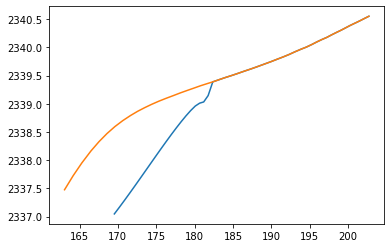

In [56]:
plt.plot(predicted_tras[202,0],predicted_tras[202,1])
plt.plot(tra[202,0],tra[202,1])

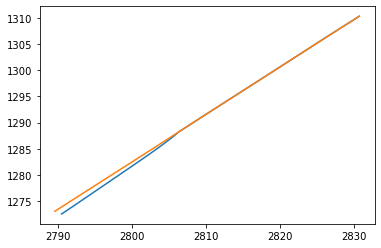

In [63]:
plt.plot(predicted_tras[203,0],predicted_tras[203,1])
plt.plot(tra[203,0],tra[203,1])

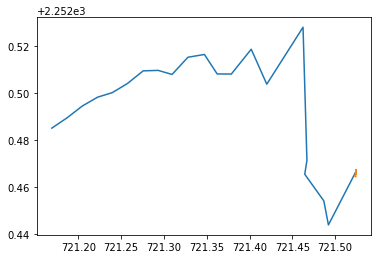

In [109]:
plt.figure()
plt.plot(predicted_tras[217,0],predicted_tras[217,1])
plt.plot(tra[217,0],tra[217,1])

In [105]:
tra[217]

array([[ 721.52440047,  721.52438515,  721.52438954,  721.52434815,
         721.52428268,  721.5242382 ,  721.52410657,  721.52434176,
         721.5243832 ,  721.52421578,  721.52409226,  721.52442526,
         721.52428135,  721.5243222 ,  721.52430183,  721.52417552,
         721.52430341,  721.52411318,  721.52438343,  721.52422606,
         721.52433878,  721.52410189,  721.5242565 ,  721.523966  ,
         721.52421984,  721.52412232,  721.52431816,  721.52423947,
         721.52440896,  721.52434665,  721.52429036,  721.52426622,
         721.52427283,  721.52408125,  721.52417109,  721.52395896,
         721.52408895,  721.52387442,  721.5235686 ,  721.52375299,
         721.52337731,  721.5235763 ,  721.52326779,  721.52358472,
         721.52357515,  721.52371887,  721.52371903,  721.52373988,
         721.52360475,  721.52370956],
       [2252.46720552, 2252.46716452, 2252.46725546, 2252.4674075 ,
        2252.46721942, 2252.46697723, 2252.46678805, 2252.46623039,
        2

In [107]:
predicted_tras[217]

array([[ 721.52440047,  721.52438515,  721.52438954,  721.52434815,
         721.52428268,  721.5242382 ,  721.52410657,  721.52434176,
         721.5243832 ,  721.52421578,  721.52409226,  721.52442526,
         721.52428135,  721.5243222 ,  721.52430183,  721.52417552,
         721.52430341,  721.52411318,  721.52438343,  721.52422606,
         721.52433878,  721.52410189,  721.5242565 ,  721.523966  ,
         721.52421984,  721.52412232,  721.52431816,  721.52423947,
         721.52440896,  721.52434665,  721.49204721,  721.48667752,
         721.46441105,  721.46696007,  721.4624062 ,  721.42007727,
         721.40193416,  721.37870881,  721.36219251,  721.34727678,
         721.32804001,  721.30949503,  721.29322962,  721.27581158,
         721.25731786,  721.2398183 ,  721.22260705,  721.20477594,
         721.18681723,  721.16910809],
       [2252.46720552, 2252.46716452, 2252.46725546, 2252.4674075 ,
        2252.46721942, 2252.46697723, 2252.46678805, 2252.46623039,
        2

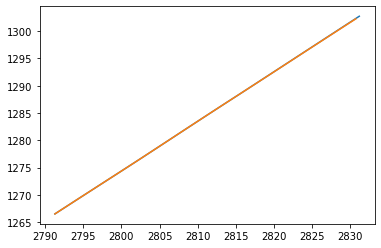

In [88]:
plt.plot(predicted_tras[218,0],predicted_tras[218,1])
plt.plot(tra[218,0],tra[218,1])

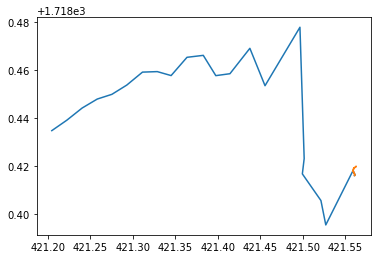

In [91]:
plt.plot(predicted_tras[219,0],predicted_tras[219,1])
plt.plot(tra[219,0],tra[219,1])

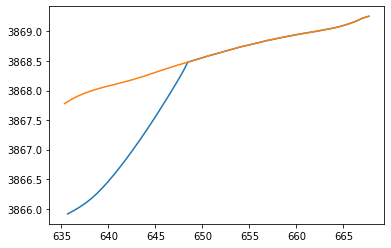

In [97]:
plt.plot(predicted_tras[224,0],predicted_tras[224,1])
plt.plot(tra[224,0],tra[224,1])

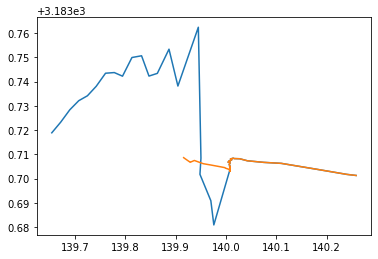

In [98]:
plt.plot(predicted_tras[225,0],predicted_tras[225,1])
plt.plot(tra[225,0],tra[225,1])

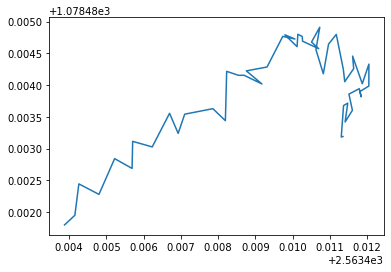

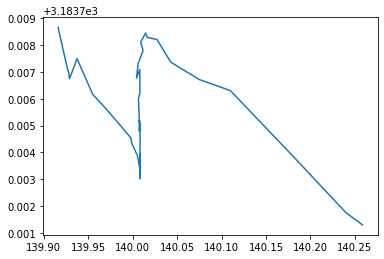

In [104]:
#plt.plot(predicted_tras[225,0],predicted_tras[225,1])
plt.figure()
plt.plot(tra[227,0],tra[227,1])
plt.figure()
plt.plot(tra[225,0],tra[225,1])

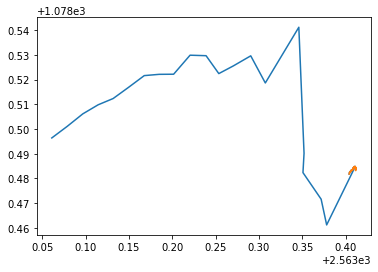

In [100]:
plt.plot(predicted_tras[227,0],predicted_tras[227,1])
plt.plot(tra[227,0],tra[227,1])

In [57]:
# compute the MSE of predicted results

np.sum((predicted_tras - tra)**2/(predicted_tras.shape[0]*20))

7.255452225060625

In [58]:
# compute the MSE of mean velocity
results_mv = np.zeros((test.shape[0],2,50))
results_mv.shape

(208272, 2, 50)

In [59]:
np.mean(train_data[:,:,0:30],axis = 2).shape

(208272, 2)

In [60]:
mean_velocity = np.mean(train_data[:,:,0:30],axis = 2)
results_mv[:,:,0:30] = tra[:,:,0:30]
for i in range(30,50):
    results_mv[:,:,i] = results_mv[:,:,i-1] + mean_velocity*0.1

In [61]:
np.sum((results_mv - tra)**2/(predicted_tras.shape[0]*20))

5.931030273515191

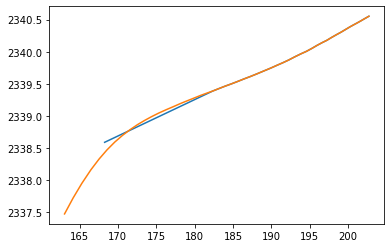

In [62]:
plt.plot(results_mv[202,0],results_mv[202,1])
plt.plot(tra[202,0],tra[202,1])

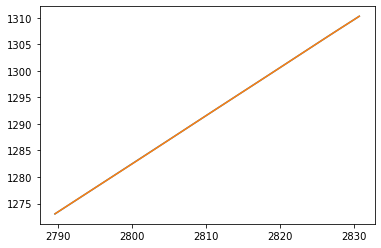

In [90]:
plt.plot(results_mv[203,0],results_mv[203,1])
plt.plot(tra[203,0],tra[203,1])

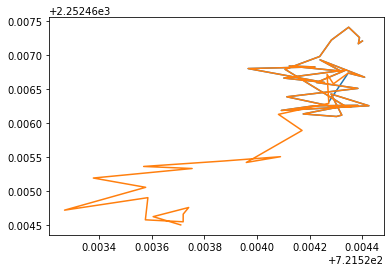

In [85]:
plt.plot(results_mv[217,0],results_mv[217,1])
plt.plot(tra[217,0],tra[217,1])